### 1. Stack Loading & Selection

Loading stack: /data3/junming/3D-TMA-Register/Amoeba_Registered_rigid_geometry/Core_06/Core_06_Amoeba_Aligned.ome.tif...
Volume Tensor Shape: (20, 8, 6080, 6080)


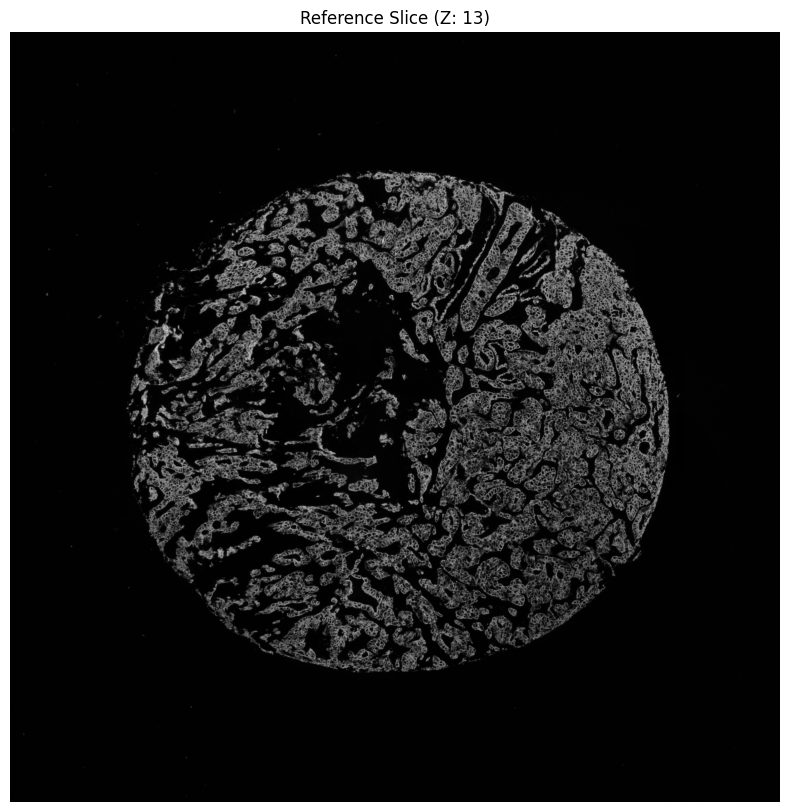

In [6]:
import tifffile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd

# --- CONFIGURATION ---
INPUT_STACK_PATH = "/data3/junming/3D-TMA-Register/Amoeba_Registered_rigid_geometry/Core_06/Core_06_Amoeba_Aligned.ome.tif"
FIXED_IDX = 13  # The "Anchor" slide
MOVING_IDX = 14 # The slide that needs residual correction

CK_CHANNEL_IDX = 6 

# --- LOAD VOLUME ---
print(f"Loading stack: {INPUT_STACK_PATH}...")
# SWE Lens: tifffile correctly parses the ZCYX metadata contract saved by your script
vol_arr = tifffile.imread(INPUT_STACK_PATH)

print(f"Volume Tensor Shape: {vol_arr.shape}")

# --- EXTRACT SPATIAL PLANES ---
# Automated dimensional branching to handle both 4D (ZCYX) and 3D (ZYX) states
if vol_arr.ndim == 4:
    fixed_slice = vol_arr[FIXED_IDX, CK_CHANNEL_IDX, :, :]
    moving_slice = vol_arr[MOVING_IDX, CK_CHANNEL_IDX, :, :]
elif vol_arr.ndim == 3:
    print("Detected 3D tensor. Assuming channel extraction was already applied.")
    fixed_slice = vol_arr[FIXED_IDX, :, :]
    moving_slice = vol_arr[MOVING_IDX, :, :]
else:
    raise ValueError(f"Unexpected tensor rank. Expected 3 or 4, got {vol_arr.ndim}")

# --- PREPROCESSING FOR OPENCV ---
def prepare_for_features(img_arr):
    """
    1. Normalizes dynamic range for localized contrast evaluation.
    2. Casts to unsigned 8bit integer type.
    3. Applies CLAHE to amplify structural textures.
    """
    norm = cv2.normalize(img_arr, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(norm)

cv_fixed = prepare_for_features(fixed_slice)
cv_moving = prepare_for_features(moving_slice)

# --- VISUALIZATION ---
plt.figure(figsize=(10,10))
plt.imshow(cv_fixed, cmap='gray')
plt.title(f"Reference Slice (Z: {FIXED_IDX})")
plt.axis('off')
plt.show()

### 2. Feature-Based

In [15]:
import time
import cv2
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')
logger = logging.getLogger(__name__)

def solve_residual_features(fixed_8bit, moving_8bit, method="ORB"):
    """
    Calculates the residual homography between two roughly aligned arrays.
    """
    t_start = time.time()
    
    # Detector Factory
    if method == "ORB":
        det = cv2.ORB_create(nfeatures=5000)
        norm = cv2.NORM_HAMMING
    elif method == "AKAZE":
        det = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif method == "SIFT":
        det = cv2.SIFT_create()
        norm = cv2.NORM_L2
    elif method == "BRISK":
        det = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        logger.error(f"Unsupported extraction methodology: {method}")
        return {"status": "Fail", "method": method, "mse": np.inf}
    
    # Detect and Compute
    kp1, des1 = det.detectAndCompute(fixed_8bit, None)
    kp2, des2 = det.detectAndCompute(moving_8bit, None)
    
    if des1 is None or des2 is None:
        logger.warning(f"Feature starvation detected using {method}.")
        return {"status": "Fail", "method": method, "mse": np.inf}

    # Nearest Neighbor Matching
    matcher = cv2.BFMatcher(norm)
    matches = matcher.knnMatch(des1, des2, k=2)
    
    # Outlier Rejection
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    if len(good_matches) < 10:
        logger.warning(f"Insufficient statistically valid matches for {method}.")
        return {"status": "Fail (Low Matches)", "method": method, "mse": np.inf}

    # Geometric Verification
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 3.0)
    H, mask = cv2.estimateAffine2D(dst_pts, src_pts, method=cv2.RANSAC,
                                    ransacReprojThreshold=3.0)
    
    # if H is None:
    #     logger.warning(f"Homography convergence failure for {method}.")
    #     return {"status": "Fail (No Converge)", "method": method, "mse": np.inf}
        
    # # Apply Spatial Warp
    # h, w = fixed_8bit.shape
    # warped = cv2.warpPerspective(moving_8bit, H, (w, h))
    if H is None:
        logger.warning(f"Affine convergence failure for {method}.")
        return {"status": "Fail (No Converge)", "method": method, "mse": np.inf}
        
    # Apply Spatial Warp
    h, w = fixed_8bit.shape
    
    # 2. Update to Affine warping
    warped = cv2.warpAffine(moving_8bit, H, (w, h))
    
    # Metric Calculation 
    f_float = fixed_8bit.astype(np.float32)
    w_float = warped.astype(np.float32)
    mse = np.mean((f_float - w_float) ** 2)
    
    t_end = time.time()
    
    return {
        "status": "Success",
        "method": method,
        "matches": len(good_matches),
        "inliers": np.sum(mask),
        "mse": mse,
        "time": t_end - t_start,
        "warped": warped,
        "H": H
    }

### 3.Execution & Lens Comparison

2026-02-22 19:42:50,877 | INFO | Baseline Mean Squared Error: 1326.24
2026-02-22 19:42:50,878 | INFO | Initiating descriptor extraction protocol: ORB
2026-02-22 19:42:52,080 | INFO | Protocol ORB complete. Matches: 23 | Inliers: 3 | MSE: 1866.04 | Improvement: -539.80
2026-02-22 19:42:52,081 | INFO | Initiating descriptor extraction protocol: AKAZE
2026-02-22 19:43:36,557 | INFO | Protocol AKAZE complete. Matches: 555 | Inliers: 53 | MSE: 969.85 | Improvement: 356.39
2026-02-22 19:43:36,559 | INFO | Initiating descriptor extraction protocol: SIFT
2026-02-22 19:44:58,280 | INFO | Protocol SIFT complete. Matches: 245 | Inliers: 12 | MSE: 958.50 | Improvement: 367.74
2026-02-22 19:44:58,281 | INFO | Initiating descriptor extraction protocol: BRISK
2026-02-22 19:46:06,056 | INFO | Protocol BRISK complete. Matches: 111 | Inliers: 9 | MSE: 1034.61 | Improvement: 291.63


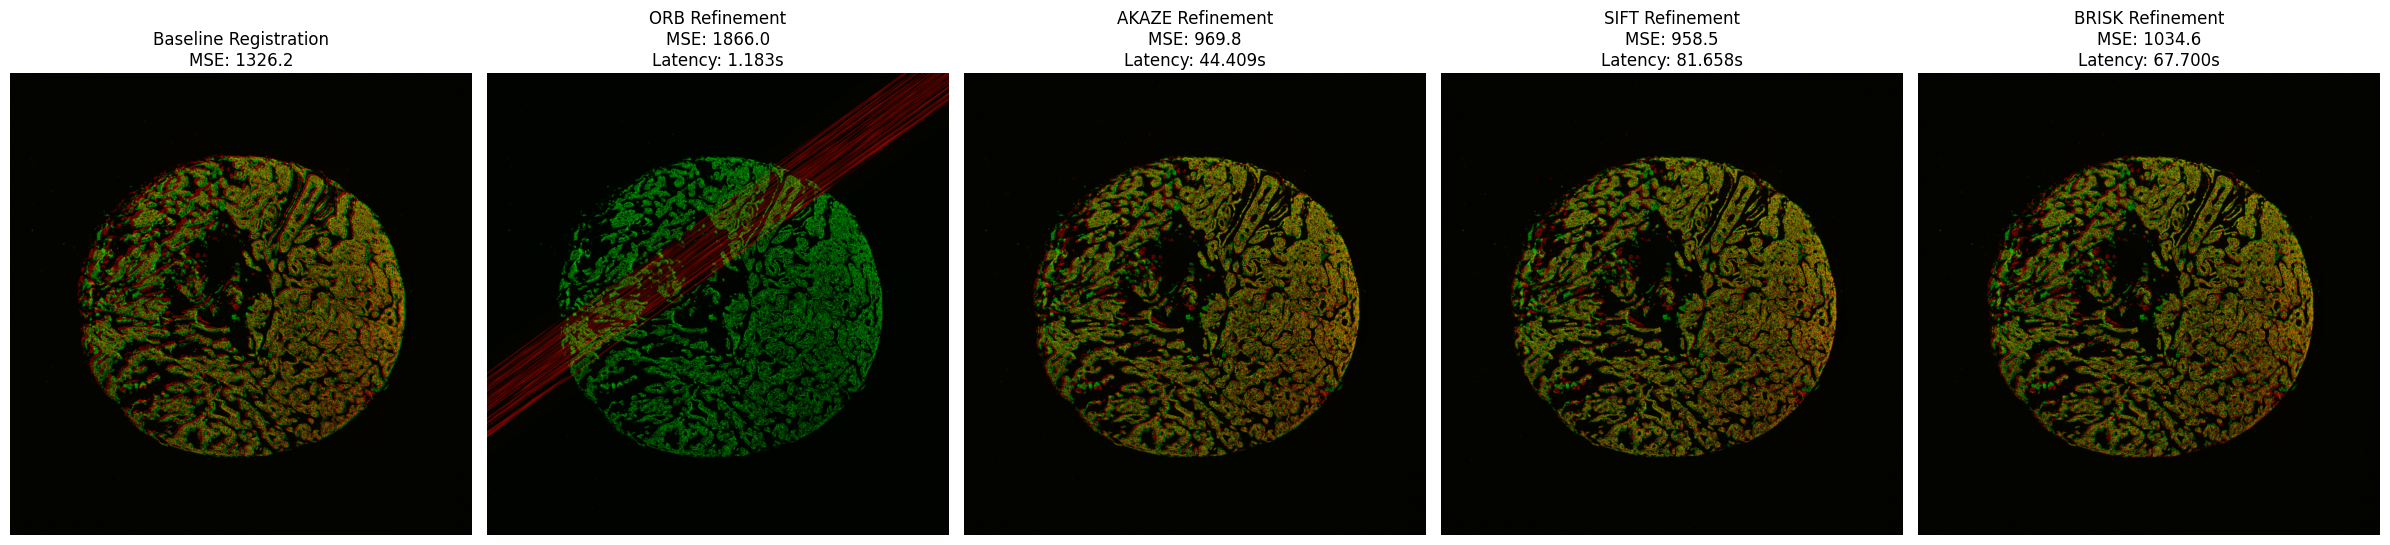

2026-02-22 19:46:40,329 | INFO | Experimental Telemetry Summary DataFrame generated.


,status,method,matches,inliers,mse,time
0,Success,ORB,23,3,1866.037476,1.182738
1,Success,AKAZE,555,53,969.847290,44.408692
2,Success,SIFT,245,12,958.496948,81.658128
3,Success,BRISK,111,9,1034.611694,67.699561


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define evaluation parameters
methods = ["ORB", "AKAZE", "SIFT", "BRISK"] 
results = []
images = {}

# Baseline Error Calculation
f_base = cv_fixed.astype(np.float32)
m_base = cv_moving.astype(np.float32)
baseline_mse = np.mean((f_base - m_base) ** 2)

logger.info(f"Baseline Mean Squared Error: {baseline_mse:.2f}")

# Execution Loop
for m in methods:
    logger.info(f"Initiating descriptor extraction protocol: {m}")
    res = solve_residual_features(cv_fixed, cv_moving, method=m)
    
    if res["status"] == "Success":
        imp = baseline_mse - res["mse"]
        logger.info(f"Protocol {m} complete. Matches: {res['matches']} | Inliers: {res['inliers']} | MSE: {res['mse']:.2f} | Improvement: {imp:.2f}")
        results.append(res)
        images[m] = res["warped"]
    else:
        logger.error(f"Protocol {m} aborted. Reason: {res['status']}")

# Visualization Rendering
if results:
    fig, axes = plt.subplots(1, len(results) + 1, figsize=(24, 8))
    
    #def make_overlay(img1, img2):
        #g = img1.astype(float) / 255.0
        #m_color = img2.astype(float) / 255.0
        #return np.dstack((m_color, g, m_color))
    
    def make_overlay(img1, img2):
        g_channel = img1.astype(float) / 255.0
        r_channel = img2.astype(float) / 255.0
        b_channel = np.zeros_like(g_channel)
        
        # Hardware RGB Indexing: (0: Red, 1: Green, 2: Blue)
        return np.dstack((r_channel, g_channel, b_channel))

    axes[0].imshow(make_overlay(cv_fixed, cv_moving))
    axes[0].set_title(f"Baseline Registration\nMSE: {baseline_mse:.1f}")
    axes[0].axis('off')
    
    for i, res in enumerate(results):
        overlay = make_overlay(cv_fixed, res["warped"])
        axes[i+1].imshow(overlay)
        axes[i+1].set_title(f"{res['method']} Refinement\nMSE: {res['mse']:.1f}\nLatency: {res['time']:.3f}s")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()
    
    # Telemetry Summary
    df = pd.DataFrame(results).drop(columns=["warped", "H"])
    logger.info("Experimental Telemetry Summary DataFrame generated.")
    display(df)

### Geometric Transformation Matrix Comparison

2026-02-22 18:02:22,228 | INFO | Initiating geometric transformation comparison protocol utilizing BRISK.


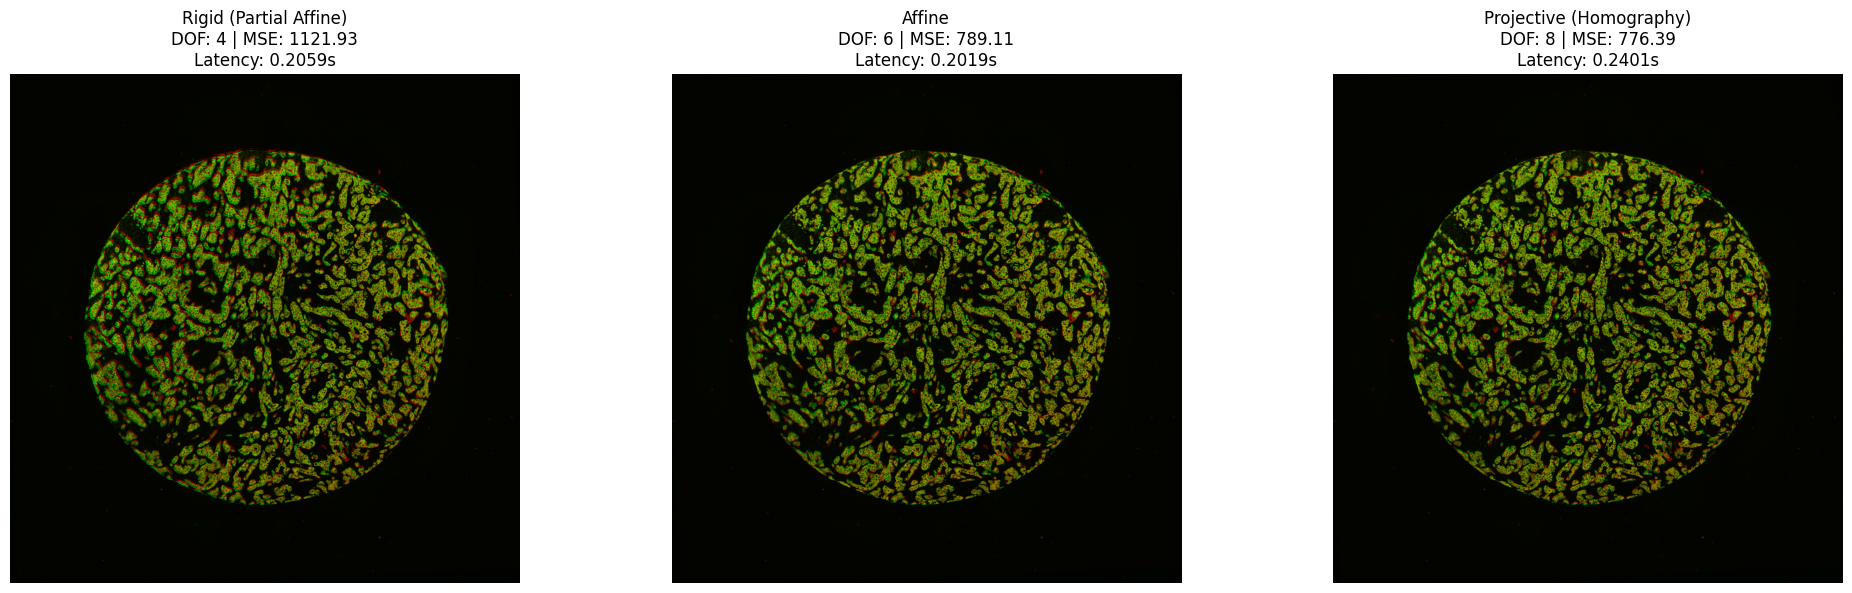

2026-02-22 18:03:02,059 | INFO | Transformation comparison telemetry generated.


,Model,DOF,MSE,Latency
0,Rigid (Partial Affine),4,1121.930298,0.205935
1,Affine,6,789.109985,0.201871
2,Projective (Homography),8,776.386841,0.240109


In [5]:
import time
import cv2
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')
logger = logging.getLogger(__name__)

def compare_geometric_transformations(fixed_8bit, moving_8bit):
    """
    Evaluates discrete parametric matrices using a unified set of BRISK descriptors.
    """
    
    # Descriptor Extraction Protocol
    # Replaced ORB with BRISK for deterministic spatial sampling
    det = cv2.BRISK_create()
    kp1, des1 = det.detectAndCompute(fixed_8bit, None)
    kp2, des2 = det.detectAndCompute(moving_8bit, None)
    
    if des1 is None or des2 is None:
        logger.error("Feature starvation detected during BRISK extraction.")
        return []

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = matcher.knnMatch(des1, des2, k=2)
    
    # Outlier Rejection Protocol
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    if len(good_matches) < 10:
        logger.error("Insufficient statistically valid matches for geometric estimation.")
        return []

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    h, w = fixed_8bit.shape
    f_float = fixed_8bit.astype(np.float32)
    
    results = []
    
    # 1. Rigid Transformation (Translation plus Rotation plus Uniform Scale)
    # Degrees of Freedom: 4
    t_start = time.time()
    matrix_rigid, inliers_rigid = cv2.estimateAffinePartial2D(
        dst_pts, src_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0
    )
    if matrix_rigid is not None:
        warp_rigid = cv2.warpAffine(moving_8bit, matrix_rigid, (w, h))
        mse_rigid = np.mean((f_float - warp_rigid.astype(np.float32)) ** 2)
        
        results.append({
            "Model": "Rigid (Partial Affine)",
            "DOF": 4,
            "MSE": mse_rigid,
            "Latency": time.time() - t_start,
            "Image": warp_rigid
        })
    else:
        logger.warning("Rigid matrix convergence failure.")
    
    # 2. Affine Transformation (Translation plus Rotation plus Scale plus Shear)
    # Degrees of Freedom: 6
    t_start = time.time()
    matrix_affine, inliers_affine = cv2.estimateAffine2D(
        dst_pts, src_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0
    )
    if matrix_affine is not None:
        warp_affine = cv2.warpAffine(moving_8bit, matrix_affine, (w, h))
        mse_affine = np.mean((f_float - warp_affine.astype(np.float32)) ** 2)
        
        results.append({
            "Model": "Affine",
            "DOF": 6,
            "MSE": mse_affine,
            "Latency": time.time() - t_start,
            "Image": warp_affine
        })
    else:
        logger.warning("Affine matrix convergence failure.")

    # 3. Projective Transformation (Homography)
    # Degrees of Freedom: 8
    t_start = time.time()
    matrix_proj, inliers_proj = cv2.findHomography(
        dst_pts, src_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0
    )
    if matrix_proj is not None:
        warp_proj = cv2.warpPerspective(moving_8bit, matrix_proj, (w, h))
        mse_proj = np.mean((f_float - warp_proj.astype(np.float32)) ** 2)
        
        results.append({
            "Model": "Projective (Homography)",
            "DOF": 8,
            "MSE": mse_proj,
            "Latency": time.time() - t_start,
            "Image": warp_proj
        })
    else:
        logger.warning("Projective matrix convergence failure.")
    
    return results

# Execution and Telemetry
logger.info("Initiating geometric transformation comparison protocol utilizing BRISK.")
transformation_results = compare_geometric_transformations(cv_fixed, cv_moving)

if transformation_results:
    # Visualization Rendering
    fig, axes = plt.subplots(1, len(transformation_results), figsize=(20, 6))
    
    def make_overlay(img1, img2):
        g_channel = img1.astype(float) / 255.0
        r_channel = img2.astype(float) / 255.0
        b_channel = np.zeros_like(g_channel)
        
        # Hardware RGB Indexing: (0: Red, 1: Green, 2: Blue)
        return np.dstack((r_channel, g_channel, b_channel))
        
    for i, res in enumerate(transformation_results):
        overlay = make_overlay(cv_fixed, res["Image"])
        axes[i].imshow(overlay)
        axes[i].set_title(f"{res['Model']}\nDOF: {res['DOF']} | MSE: {res['MSE']:.2f}\nLatency: {res['Latency']:.4f}s")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
    # Telemetry Summary
    df_transforms = pd.DataFrame(transformation_results).drop(columns=["Image"])
    logger.info("Transformation comparison telemetry generated.")
    display(df_transforms)